# DM-36026: ApPipe on DC2, October 2022

New baseline run, still using "old diffim" (before the big refactor).

* Uses `DC2` skymap
* Templates from four goodSeeingCoadd patches 4431 (DC2) are in `/sdf/group/rubin/repo/main/u/elhoward/DM-36026/templates/20221025T211333Z`
* Final processing of DC2 patch_4431 is in `u/elhoward/DM-36026/DC2-4patch_4431-full`
* Postgres schema is `elhoward_dm36026_dc2_appipe`
* Working directory on USDF with bps logs, pipelines, etc. is `/project/elhoward/repo-main-logs/DM-36026`

For ApTemplate.yaml:
```
inCollection: u/mrawls/DM-34827/defaults/4patch_4431
dataQuery: "skymap='DC2'"
```
For ApPipe.yaml:
```
inCollection: u/mrawls/DM-34827/defaults/4patch_4431,u/elhoward/DM-36026/templates/20221025T211333Z
dataQuery: "skymap='DC2'"
```

## Table of Contents

1. Loading DiaObjects and DiaSources
2. Typical "quick look analysis" plots
3. SNR distributions

In [1]:
%matplotlib widget

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import importlib
import pandas as pd

from astropy.coordinates import SkyCoord
import astropy.units as u

import lsst.geom
import lsst.daf.butler as dafButler
from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig

sys.path.append('/sdf/data/rubin/u/elhoward/repos/ap_pipe-notebooks/')
import diaObjectAnalysis as doa
import apdbPlots as pla
import plotLightcurve as plc
import coaddAnalysis as coa

Overriding default configuration file with /opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-4.1.0/Linux64/dustmaps_cachedata/g41a3ec361e+62d12e78cb/config/.dustmapsrc


In [2]:
# Only if you change anything in the code imported above
importlib.reload(doa)
importlib.reload(pla)
importlib.reload(plc)
importlib.reload(coa)

<module 'coaddAnalysis' from '/sdf/data/rubin/u/elhoward/repos/ap_pipe-notebooks/coaddAnalysis.py'>

## 1. Loading DiaObjects and DiaSources

In [3]:
repo = '/repo/dc2'
butler = dafButler.Butler(repo)
collections = 'u/elhoward/DM-36026/DC2-4patch_4431-full' #payloadName from bps yaml
instrument = 'LSSTCam-imSim'
skymap = 'DC2'
schema = 'elhoward_dm36026_dc2_appipe'

dbType='postgres'
dbName='lsst-devl'

month = 'October'
year = '2022'

In [4]:
badFlagList = ['base_PixelFlags_flag_bad',
               'base_PixelFlags_flag_suspect',
               'base_PixelFlags_flag_saturatedCenter',
               'base_PixelFlags_flag_interpolated',
               'base_PixelFlags_flag_interpolatedCenter',
               'base_PixelFlags_flag_edge',
              ]

In [5]:
objTable, srcTable, goodObj, goodSrc = pla.loadTables(repo,
                                                      dbType=dbType,
                                                      dbName=dbName,
                                                      schema=schema,
                                                      gen='gen3',
                                                      instrument=instrument,
                                                      badFlagList=badFlagList)

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [6]:
srcTable = pla.addVisitCcdToSrcTable(srcTable, instrument=instrument, gen='gen3', butler=butler)
flagTable, srcTableFlags, flagFilter, goodSrc, goodObj = pla.makeSrcTableFlags(srcTable, objTable,
                                                                               badFlagList=badFlagList,
                                                                               gen='gen3', instrument=instrument,
                                                                               repo=repo)

In [7]:
objTable.columns

Index(['diaObjectId', 'ra', 'decl', 'nDiaSources', 'gPSFluxMean',
       'rPSFluxMean', 'iPSFluxMean', 'zPSFluxMean', 'yPSFluxMean',
       'validityEnd', 'flags'],
      dtype='object')

In [8]:
srcTable.columns

Index(['diaSourceId', 'diaObjectId', 'ra', 'decl', 'ccdVisitId', 'midPointTai',
       'apFlux', 'psFlux', 'apFluxErr', 'psFluxErr', 'totFlux', 'totFluxErr',
       'x', 'y', 'snr', 'ixxPSF', 'iyyPSF', 'ixyPSF', 'flags', 'filterName',
       'visit', 'ccd'],
      dtype='object')

In [9]:
# Unpack the flags column and create a flag table
from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig
config = TransformDiaSourceCatalogConfig()
unpacker = UnpackApdbFlags(config.flagMap, 'DiaSource')
flagValues = unpacker.unpack(srcTable['flags'].astype(int), 'flags')
flagTable = pd.DataFrame(flagValues, index=srcTable.index)
diaSourcesFlagged = pd.concat([srcTable,flagTable], axis=1)

## 2. Typical "quick look analysis" plots

Including a visual comparison of an older Dec 2021 processing run

Text(0.5, 1.0, 'DIA Objects, October 2022')

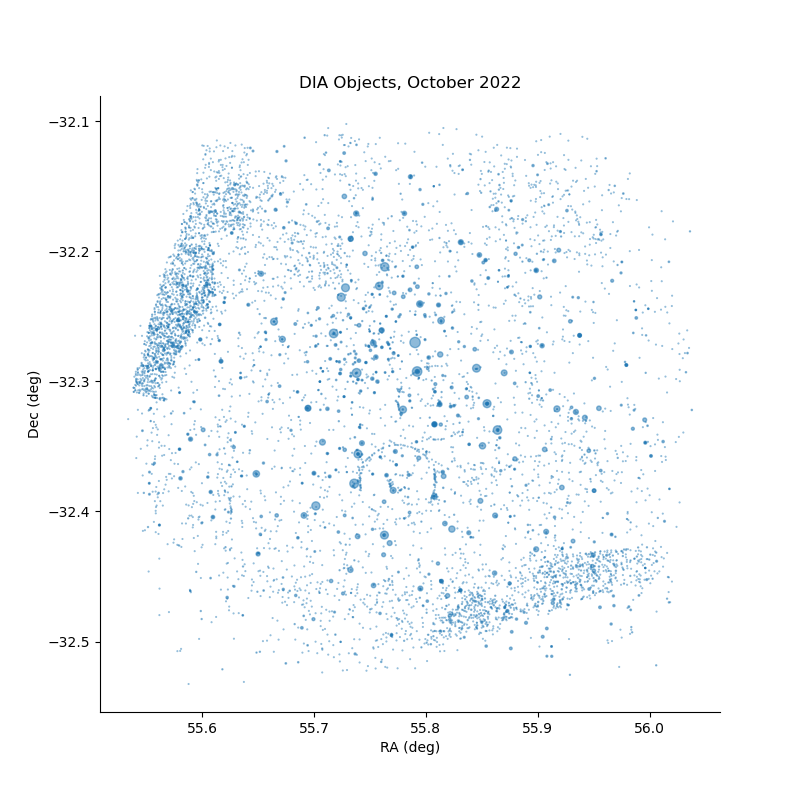

In [10]:
fig = plt.figure(figsize=(8,8))

cutoff = 0  # only plot DIA Objects composed more than cutoff DIA Sources

ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.scatter(goodObj.loc[goodObj['nDiaSources'] > cutoff, 'ra'], goodObj.loc[goodObj['nDiaSources'] > cutoff, 'decl'], 
           c='C0', s=goodObj.loc[goodObj['nDiaSources'] > cutoff, 'nDiaSources'], marker='.', alpha=0.5)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_title(f'DIA Objects, {month} {year}')

Text(0.5, 1.0, 'DIA Objects composed of > 2 DIA Sources, October 2022')

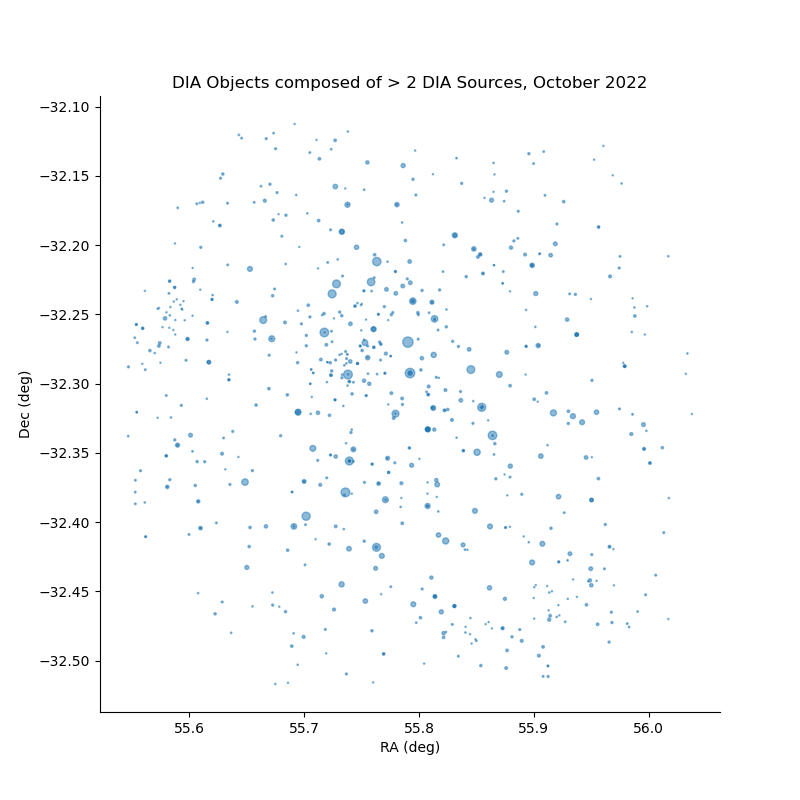

In [11]:
fig = plt.figure(figsize=(8,8))

cutoff = 2  # only plot DIA Objects composed more than cutoff DIA Sources

ax = fig.add_subplot(111)
#plt.setp(ax, xlim=xlim, ylim=ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.scatter(goodObj.loc[goodObj['nDiaSources'] > cutoff, 'ra'], goodObj.loc[goodObj['nDiaSources'] > cutoff, 'decl'], 
           c='C0', s=goodObj.loc[goodObj['nDiaSources'] > cutoff, 'nDiaSources'], marker='.', alpha=0.5)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_title(f'DIA Objects composed of > 2 DIA Sources, {month} {year}')

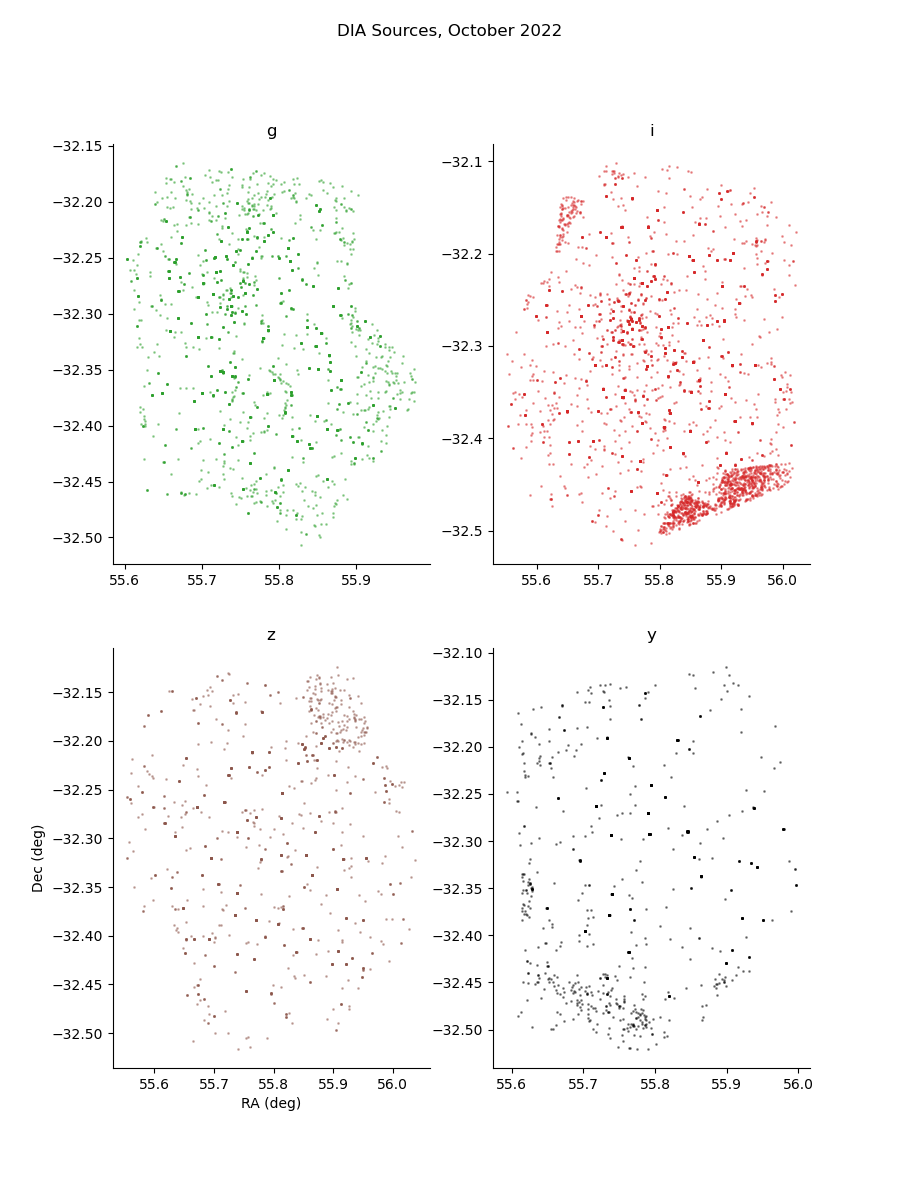

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(9, 12))

axG = axs[0, 0]
axI = axs[0, 1]
axZ = axs[1, 0]
axY = axs[1, 1]

axList = [axG, axI, axZ, axY]
colorList = ['C2', 'C3', 'C5', 'k']

fig.suptitle(f'DIA Sources, {month} {year}')
pSize = 1

goodGFilter = (goodSrc['filterName'] == 'g')
goodIFilter = (goodSrc['filterName'] == 'i')
goodZFilter = (goodSrc['filterName'] == 'z')
goodYFilter = (goodSrc['filterName'] == 'y')

filterList = [goodGFilter, goodIFilter, goodZFilter, goodYFilter]

for ax, filtered, color in zip(axList, filterList, colorList):
    ax.scatter(goodSrc.loc[filtered, 'ra'], goodSrc.loc[filtered, 'decl'], c=color, s=pSize, marker='o', alpha=0.4)

axZ.set_xlabel('RA (deg)')
axZ.set_ylabel('Dec (deg)')

axG.set_title('g')
axI.set_title('i')
axZ.set_title('z')
axY.set_title('y')

for ax in axList:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

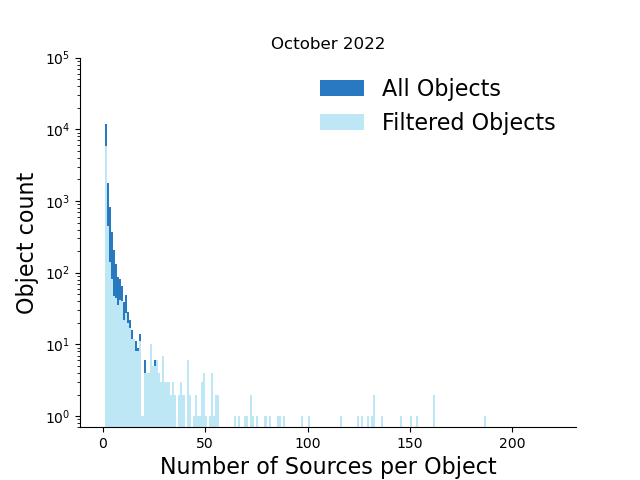

In [13]:
hist = doa.plotDiaObjectHistogram(objTable, goodObj, title=f'{month} {year}')

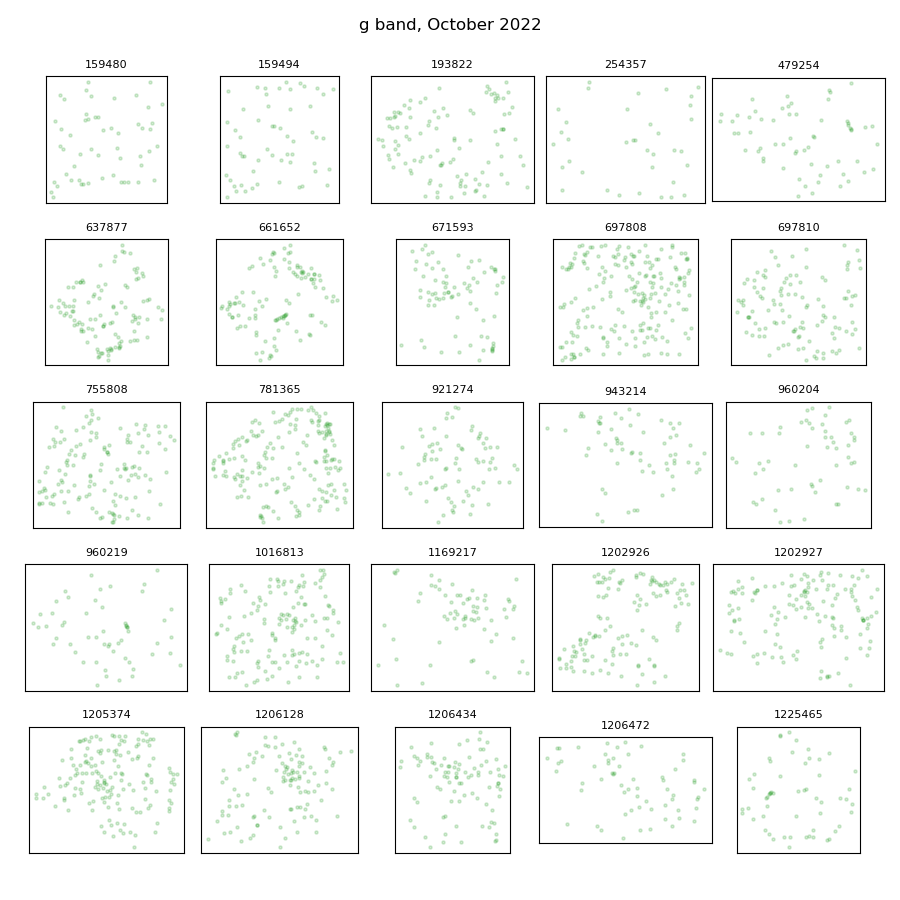

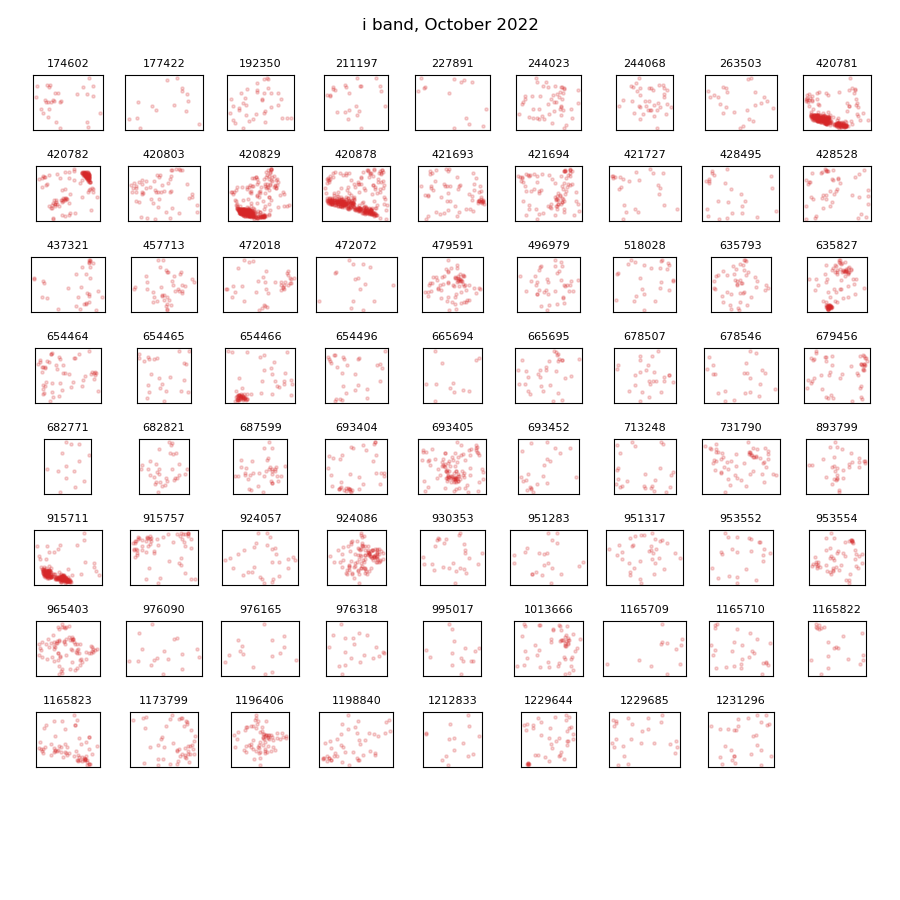

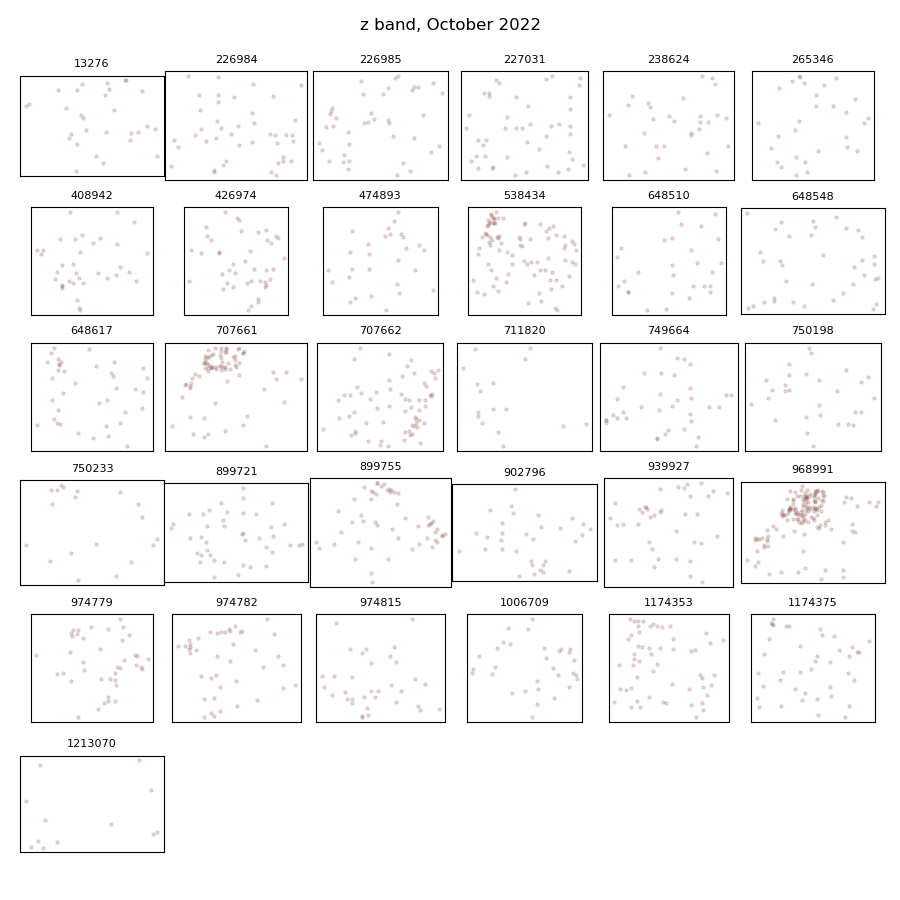

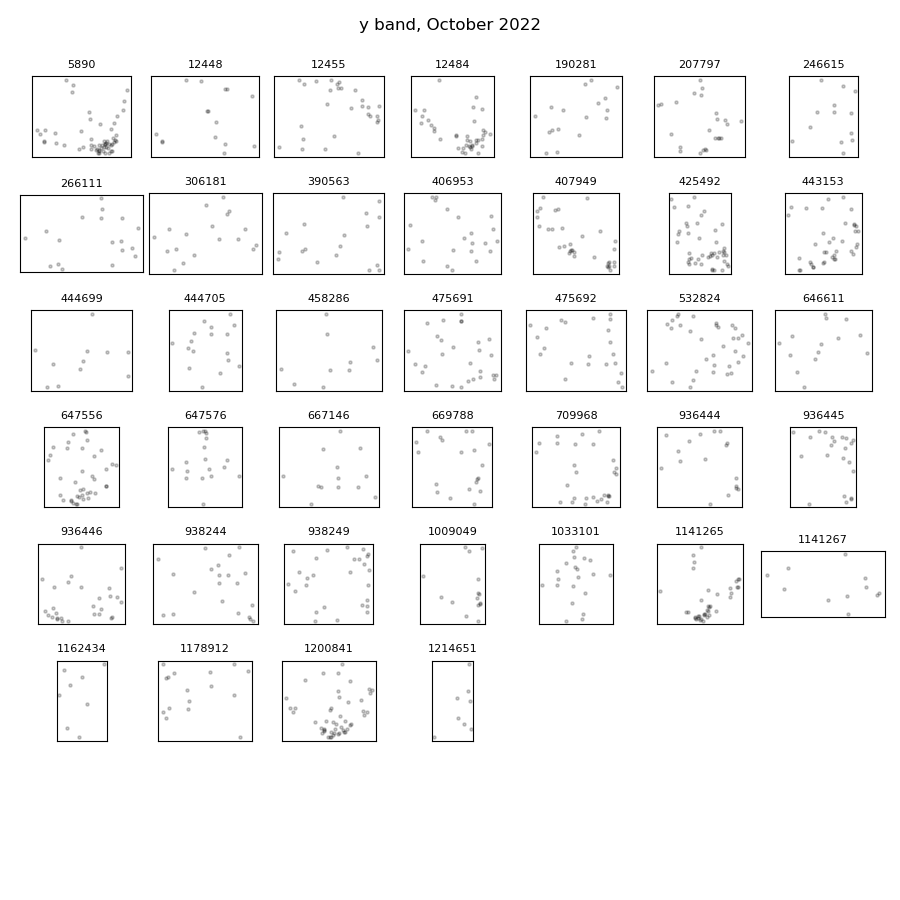

In [14]:
bandList = ['g', 'i', 'z', 'y']
colorList = ['C2', 'C3', 'C5', 'k']

for band, color in zip(bandList, colorList):
    pla.plotDiaSourcesOnSkyGrid(repo, goodSrc.loc[goodSrc['filterName'] == band], title=band+f' band, {month} {year}', color=color, size=20)

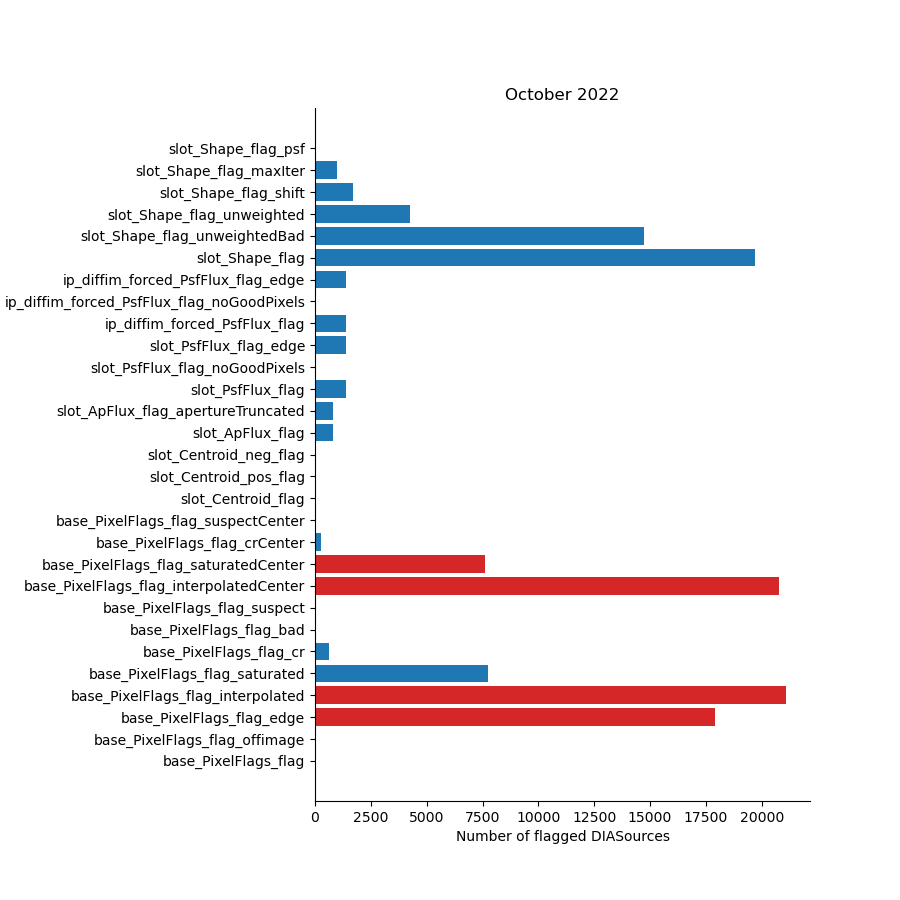

In [15]:
pla.plotFlagHist(srcTable, badFlagList=badFlagList, title=f'{month} {year}')

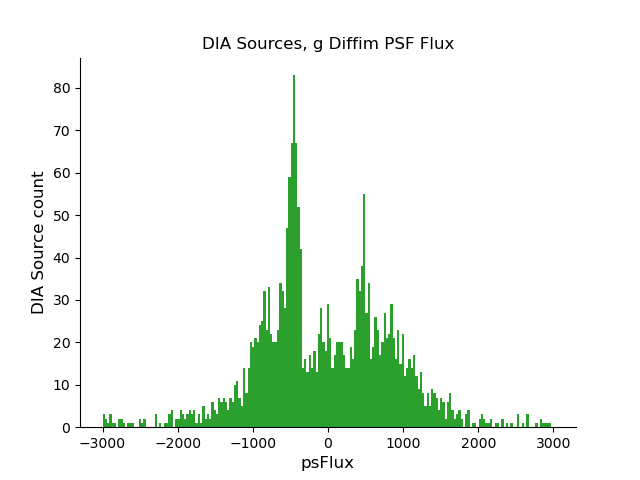

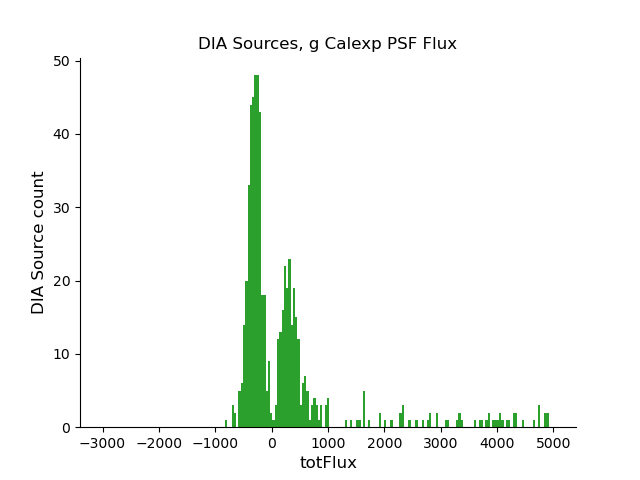

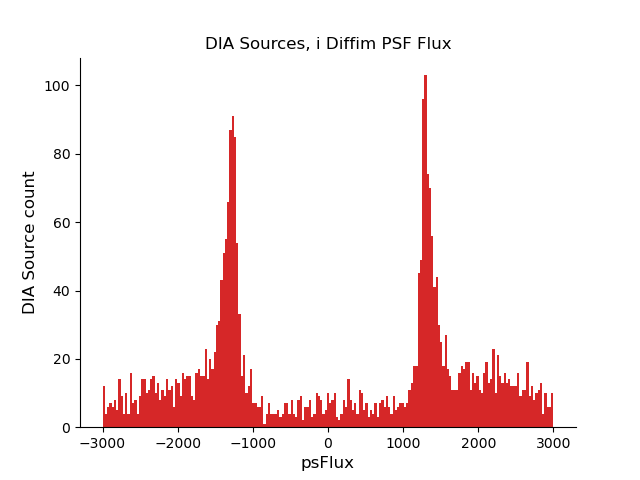

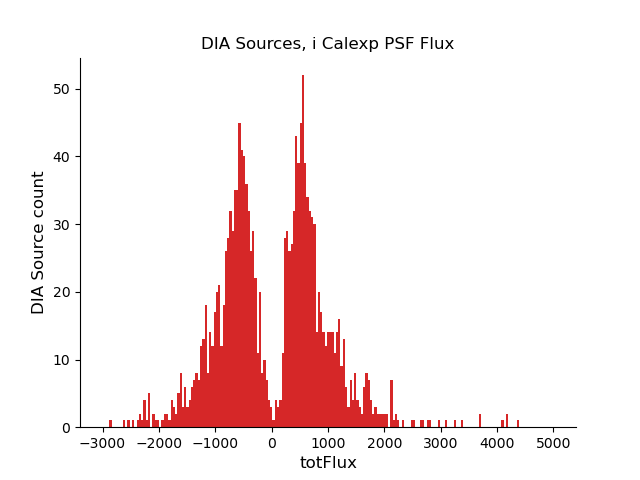

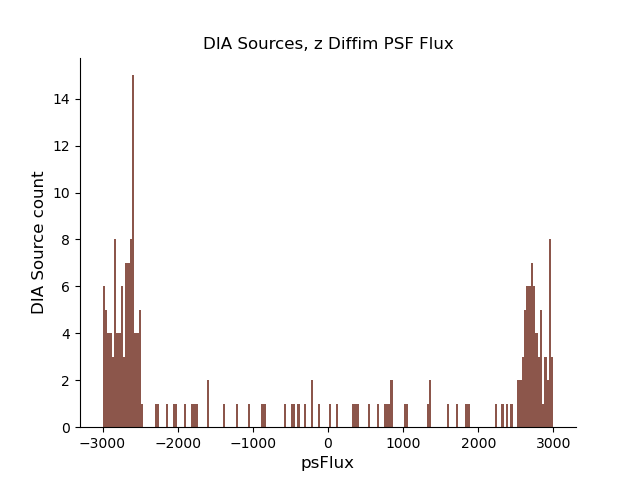

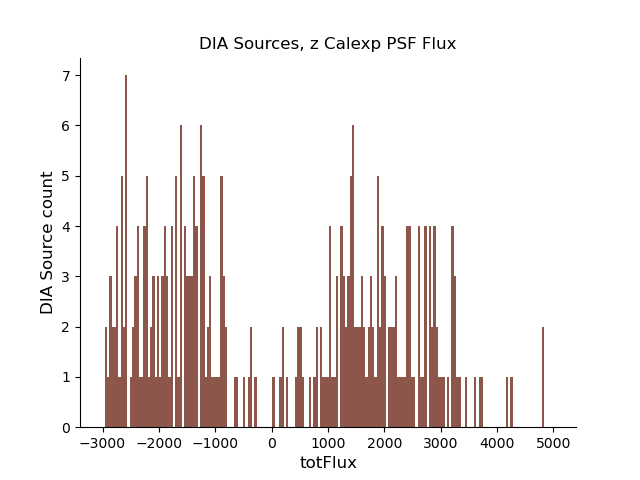

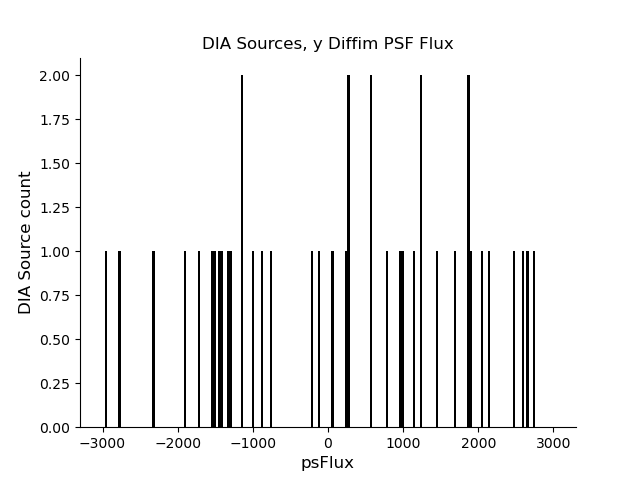

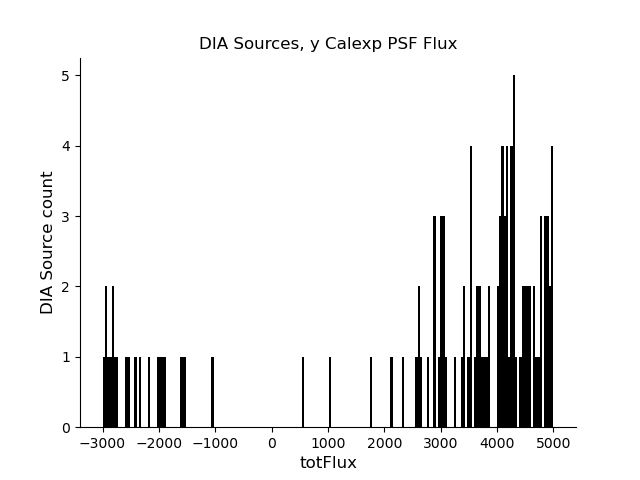

In [16]:
for band, color in zip(bandList, colorList):
    pla.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == band], fluxType='psFlux',
                        title=f'DIA Sources, {band} Diffim PSF Flux', color1=color, binmin=-3e3, binmax=3e3)
    pla.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == band], fluxType='totFlux',
                        title=f'DIA Sources, {band} Calexp PSF Flux', color1=color, binmin=-3e3, binmax=5e3)

## 3. SNR distributions

For both difference image fluxes (psFlux) and forced source photometry fluxes (totFlux)

In [17]:
# SNR is basically just flux/fluxErr for our purposes
# There is now an actual `snr` column in the DiaSource table too, even better!

Text(0.5, 0, 'SNR of DIA Sources')

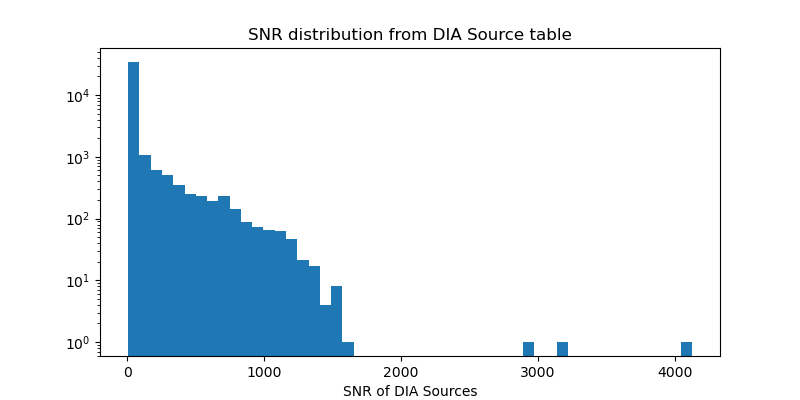

In [18]:
plt.figure(figsize=(8,4))
plt.yscale('log')
snrHist = plt.hist(srcTable.snr, bins=50)
plt.title('SNR distribution from DIA Source table')
plt.xlabel('SNR of DIA Sources')

In [19]:
# Pre-snr column:
srcTable['psFluxSNR'] = srcTable.psFlux / srcTable.psFluxErr
srcTable['totFluxSNR'] = srcTable.totFlux / srcTable.totFluxErr

Text(0.5, 0, 'psFlux/psFluxErr')

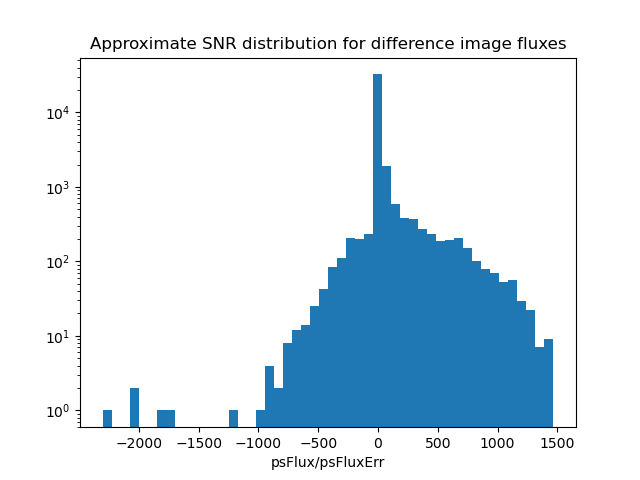

In [20]:
plt.figure()
plt.yscale('log')
psFluxHist = plt.hist(srcTable.psFluxSNR, bins=50)
plt.title('Approximate SNR distribution for difference image fluxes')
plt.xlabel('psFlux/psFluxErr')

Text(0.5, 0, 'totFlux/totFluxErr')

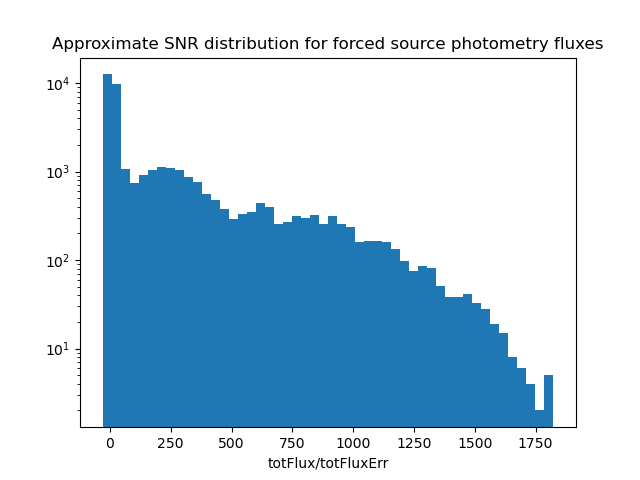

In [21]:
plt.figure()
plt.yscale('log')
totFluxHist = plt.hist(srcTable.totFluxSNR, bins=50)
plt.title('Approximate SNR distribution for forced source photometry fluxes')
plt.xlabel('totFlux/totFluxErr')